# Trilogy color images

Adapting for use in a Python Jupyter notebook

In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
from os.path import join
from os.path import expanduser
home = expanduser("~")

import astropy  # version 4.2 is required to write magnitudes to ecsv file
import astropy.io.fits as pyfits
from astropy.io import fits
import astropy.wcs as wcs
from astropy.table import QTable, Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, LinearStretch, hist
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats

from importlib import reload

In [2]:
#%matplotlib inline
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
# https://matplotlib.org/tutorials/introductory/customizing.html\n",
#plt.style.use('/Users/dcoe/p/matplotlibrc.txt')
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
#filters = 'F277W F356W F444W F480M'.split()
filters = 'F277W F356W F444W'.split()
#filters = 'F115W F150W F200W'.split()
image_files = ['images/%s/MACS0647_%s_i2d.fits' % (filt, filt) for filt in filters]
num_images = len(image_files)
image_files

['images/F277W/MACS0647_F277W_i2d.fits',
 'images/F356W/MACS0647_F356W_i2d.fits',
 'images/F444W/MACS0647_F444W_i2d.fits']

In [4]:
for i in range(num_images):
    hdu = pyfits.open(image_files[i])
    data = hdu[1].data
    ny, nx = data.shape
    imwcs = wcs.WCS(hdu[1].header, hdu)
    # image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
    image_pixel_scale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
    image_pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
    outline = '%d x %d pixels' % (ny, nx)
    outline += ' = %d" x %d"' % (ny * image_pixel_scale, nx * image_pixel_scale)
    outline += " = %.1f' x %.1f'" % (ny * image_pixel_scale / 60., nx * image_pixel_scale / 60.)
    outline += ' (%.2f" / pixel)' % image_pixel_scale
    print(outline)

4544 x 4558 pixels = 136" x 136" = 2.3' x 2.3' (0.03" / pixel)
4544 x 4558 pixels = 136" x 136" = 2.3' x 2.3' (0.03" / pixel)
4544 x 4558 pixels = 136" x 136" = 2.3' x 2.3' (0.03" / pixel)


<IPython.core.display.Javascript object>


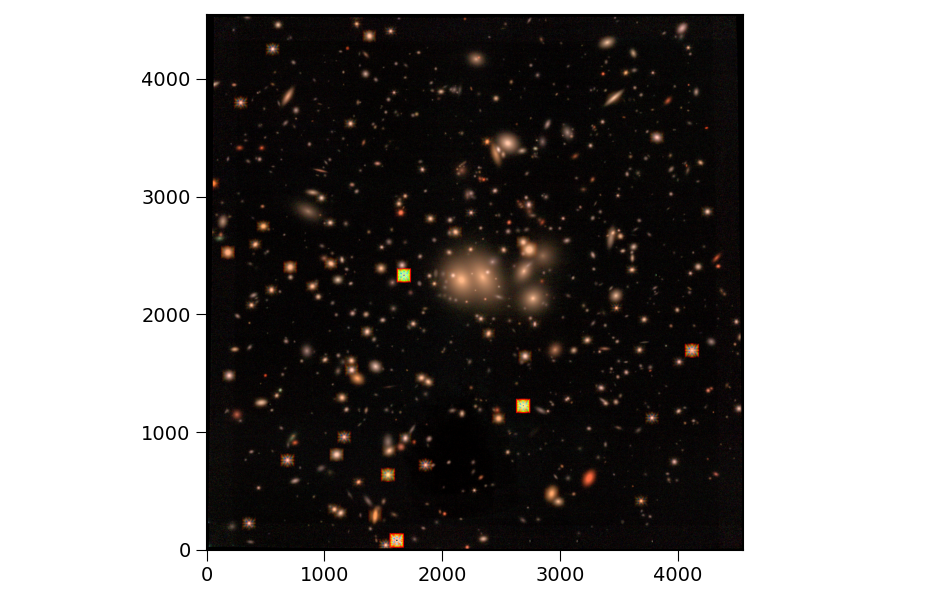

In [5]:
# Lupton color image
# 3 NIRCam long wavelength channel images
r = fits.open(image_files[2])[1].data
g = fits.open(image_files[1])[1].data
b = fits.open(image_files[0])[1].data
#color_image = make_lupton_rgb(r, g, b, Q=5, stretch=0.02)
color_image = make_lupton_rgb(r, g, b, Q=10, stretch=0.07)
#color_image = make_lupton_rgb(r, g, b, Q=10, stretch=0.2, minimum=(0.25, 0.11, 0.12))
fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
plt.imshow(color_image, origin='lower')

In [ ]:
#fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
#plt.imshow(color_image, origin='lower')
#plt.xlabel('Right Ascension')
#plt.ylabel('Declination')
#plt.title('Short Wavelength Channel')

<IPython.core.display.Javascript object>


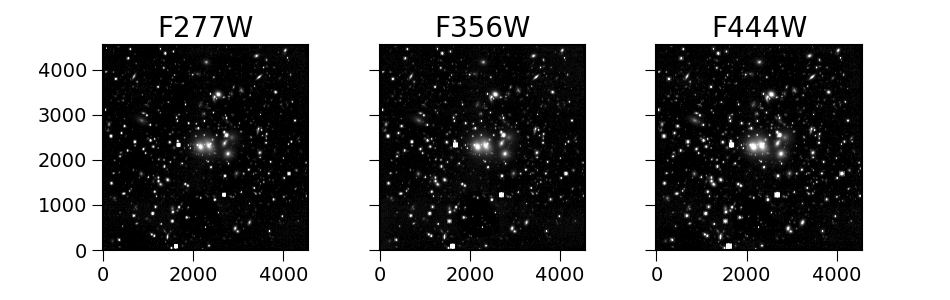

Interactive zoom / pan controls all images simultaneously


In [6]:
# Show each image as grayscale

fig, ax = plt.subplots(1, num_images, sharex=True, sharey=True, figsize=(9.5, 3))
# For RA,Dec axes instead of pixels, add: , subplot_kw={'projection': imwcs})

norm_images = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=1)

for i in range(num_images):
    data = pyfits.open(image_files[i])[1].data
    ax[i].imshow(data, origin='lower', cmap='Greys_r', norm=norm_images)
    ax[i].set_title(filters[i])

fig.tight_layout()

print('Interactive zoom / pan controls all images simultaneously')

In [7]:
# Trilogy

from scipy.optimize import golden

def da(k):
    a1 = k * (x1 - x0) + 1
    a2 = k * (x2 - x0) + 1
    a1n = a1**n
    a1n = np.abs(a1n)  # Don't want the solutions where a1 & a2 are both negative!
    da1 = a1n - a2
    k = np.abs(k)
    if k == 0:
        return da(1e-10)
    else:
        da1 = da1 / k  # To avoid solution k = 0!
    return abs(da1)

def imscale2(data, levels, y1):
    # x0, x1, x2  YIELD  0, y1, 1,  RESPECTIVELY
    # y1 = noiselum
    global n, x0, x1, x2  # So that golden can use them
    x0, x1, x2 = levels  
    if y1 == 0.5:
        k = (x2 - 2 * x1 + x0) / float(x1 - x0) ** 2
    else:
        n = 1 / y1
        k = np.abs(golden(da))
    r1 = np.log10( k * (x2 - x0) + 1)
    v = np.ravel(data)
    v = clip2(v, 0, None)
    d = k * (v - x0) + 1
    d = clip2(d, 1e-30, None)
    z = np.log10(d) / r1
    z = np.clip(z, 0, 1)
    z.shape = data.shape
    z = z * 255
    z = z.astype(np.uint8)
    return z

def clip2(m, m_min=None, m_max=None):
    if m_min == None:
        m_min = np.min(m)
    if m_max == None:
        m_max = np.max(m)
    return np.clip(m, m_min, m_max)


# PREVIOUSLY in colorimage.py
def set_levels(data, pp, stripneg=False, sortedalready=False):
    if sortedalready:
        vs = data
    else:
        print('sorting...')
        vs = np.sort(data.flat)
    if stripneg:  # Get rid of negative values altogether!
        # This is the way I was doing it for a while
        # Now that I'm not, resulting images should change (get lighter)
        i = np.searchsorted(vs, 0)
        vs = vs[i+1:]
    else:  # Clip negative values to zero
        vs = clip2(vs, 0, None)
    ii = np.array(pp) * len(vs)
    ii = ii.astype(int)
    ii = np.clip(ii, 0, len(vs)-1)
    levels = vs.take(ii)
    #print ii, levels, vs, sort(vs)
    return levels


def determine_scaling(data, unsatpercent, noisesig=1, correctbias=True, noisesig0=2):
    """Determines data values (x0,x1,x2) which will be scaled to (0,noiselum,1)"""
    # Robust mean & standard deviation
    datasorted = data + 0
    datasorted[np.isnan(datasorted)]=0  # set all nan values to zero
    datasorted = np.sort(datasorted.flat)
    if datasorted[0] == datasorted[-1]:  # data is all one value
        levels = 0, 1, 100  # whatever
    else:
        data_mean, data_median, data_stddev = sigma_clipped_stats(datasorted)
        m = data_mean
        r = data_stddev
        print('%g +/- %g' % (m, r))

        if correctbias:
            x0 = m - noisesig0 * r
        else:
            x0 = 0
        x1 = m + noisesig * r
        x2 = set_levels(datasorted, np.array([unsatpercent]), sortedalready=True)[0]
        levels = x0, x1, x2
    return levels

In [8]:
noiselum = 0.12
satpercent = 0.1
unsatpercent = 1 - 0.01 * satpercent

In [9]:
scaled_images = []
for i in range(3):
    image_file = image_files[i]
    print(image_file)
    data = pyfits.open(image_file)[1].data
    levels = determine_scaling(data.ravel(), unsatpercent)
    print(levels)
    print()
    scaled = imscale2(data, levels, noiselum)
    scaled_images.append(scaled)

images/F277W/MACS0647_F277W_i2d.fits
8.01522e-05 +/- 0.00597396
(-0.01186777398106642, 0.006054115219740197, 3.4876895)

images/F356W/MACS0647_F356W_i2d.fits
0.000833568 +/- 0.00584934
(-0.010865114454645663, 0.006682909734081477, 4.7112446)

images/F444W/MACS0647_F444W_i2d.fits
0.000683013 +/- 0.00778215
(-0.014881294686347246, 0.008465166669338942, 5.4832306)



In [10]:
imrgb = np.array(scaled_images[::-1]).transpose((1,2,0))

<IPython.core.display.Javascript object>


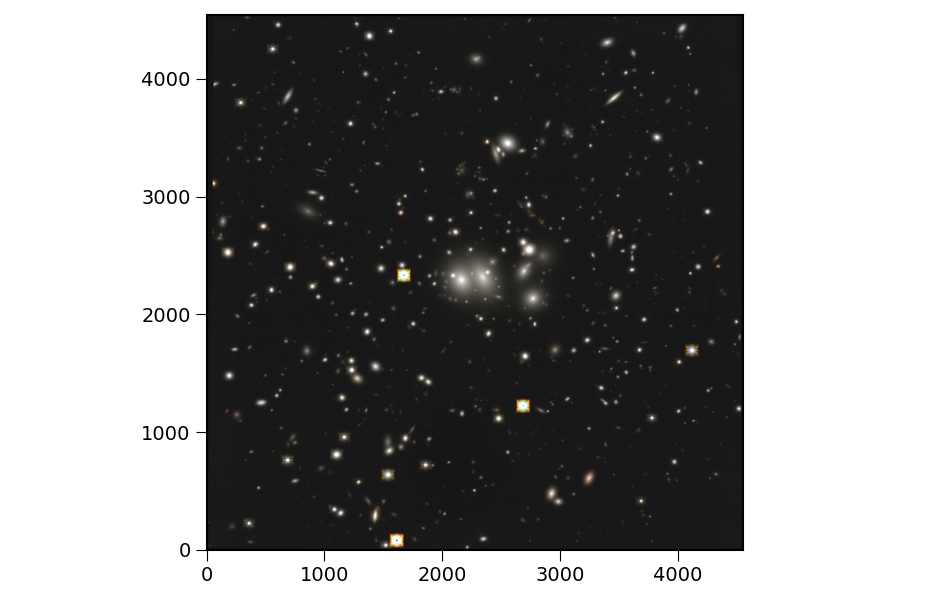

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
plt.imshow(imrgb, origin='lower')

In [12]:
import matplotlib
matplotlib.image.imsave('MACS0647_LW_color.png', imrgb)